In [18]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np


In [19]:
data = pd.read_csv("../data/pm25_pm10_merged.csv")  # 파일 경로 수정 필요
data['Date'] = pd.to_datetime(data['Date'])
initial_centroids = np.array([[5], [17.5], [37.5], [60]])

In [20]:
def assign_pm25_cluster(pm25):
    if pm25 <= 10:
        return 0  # "좋음"
    elif pm25 <= 25:
        return 1  # "보통"
    elif pm25 <= 50:
        return 2  # "나쁨"
    else:
        return 3  # "매우 나쁨"

In [21]:
def train_model(data):
    # Pivot 데이터 만들기
    pivot_data = data.pivot(index='Date', columns='City', values='PM2.5 (µg/m³)').reset_index().fillna(0)
    X = pivot_data[['Beijing']]  # 입력 변수: Beijing PM2.5만 사용
    y = pivot_data[['Seoul', 'Tokyo', 'Delhi', 'Bangkok']]  # 출력 변수

    # WHO 기준에 맞춰 KMeans 초기 중심 설정
    initial_centroids = np.array([[5], [17.5], [37.5], [60]])  # WHO 기준 PM2.5 값 기반

    # 데이터 정규화 (KMeans가 거리 기반이므로 스케일링 필요)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # KMeans로 데이터 군집화
    kmeans = KMeans(n_clusters=4, init=initial_centroids, n_init=1, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    pivot_data['Cluster'] = clusters

    # 각 군집별로 모델 학습
    models = {}
    X_tests = {}
    y_tests = {}

    for cluster in range(kmeans.n_clusters):
        cluster_data = pivot_data[pivot_data['Cluster'] == cluster]
        X_cluster = cluster_data[['Beijing']]
        y_cluster = cluster_data[['Seoul', 'Tokyo', 'Delhi', 'Bangkok']]

        if len(X_cluster) > 10:  # 데이터가 너무 적으면 학습하지 않음
            X_train, X_test, y_train, y_test = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)
            model = RandomForestRegressor(n_estimators=2000, random_state=42)
            model.fit(X_train, y_train)
            models[cluster] = model
            X_tests[cluster] = X_test
            y_tests[cluster] = y_test

    return models, kmeans, X_tests, y_tests, pivot_data, scaler 

In [22]:
def predict_pm25(models, kmeans, scaler, beijing_pm25):
    beijing_scaled = scaler.transform([[beijing_pm25]])  # 스케일 변환
    cluster = kmeans.predict(beijing_scaled)[0]  # 군집 예측
    model = models.get(cluster, None)  # 해당 군집 모델 가져오기

    if model:
        prediction = model.predict([[beijing_pm25]])[0]  # 1차원 리스트로 반환됨
        city_names = ["Seoul", "Tokyo", "Delhi", "Bangkok"]  # 예측할 도시 리스트
        return dict(zip(city_names, prediction))  # 도시명과 예측값 매핑하여 반환
    else:
        return None


In [23]:
def score_model(models, X_tests, y_tests):
    scores = {}

    for cluster, model in models.items():
        X_test = X_tests[cluster]
        y_test = y_tests[cluster]

        # 모델의 R² 스코어 계산
        r2_score = model.score(X_test, y_test)

        # 결과 저장 (군집별 R² 스코어)
        scores[cluster] = r2_score

    return scores


In [24]:
def plot_clusters(pivot_data, kmeans):
    plt.scatter(pivot_data['Beijing'], pivot_data['Cluster'], c=pivot_data['Cluster'], cmap='viridis')
    plt.colorbar(label="Cluster")
    plt.xlabel("Beijing PM2.5")
    plt.ylabel("Cluster")
    plt.title("WHO 기준 KMeans 군집화")
    plt.show()


In [25]:
city_coords = {
    'Seoul': (37.5665, 126.978),
    'Tokyo': (35.6895, 139.6917),
    'Beijing': (39.9042, 116.4074),
    'Delhi': (28.7041, 77.1025),
    'Bangkok': (13.7563, 100.5018)
}

/opt/anaconda3/envs/pystudy_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/pystudy_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/pystudy_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44400 (\N{HANGUL SYLLABLE GUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/pystudy_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51665 (\N{HANGUL SYLLABLE JIB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/pystudy_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missi

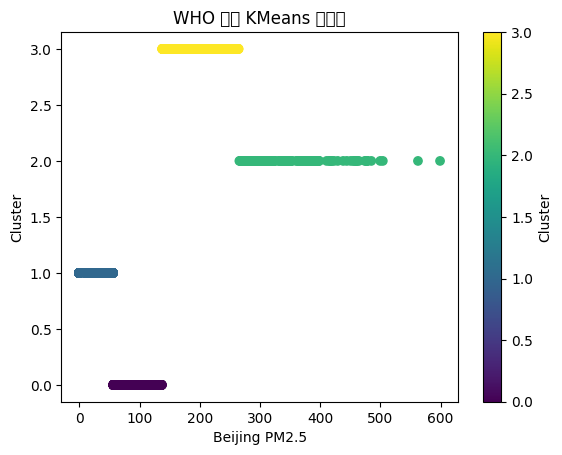

/opt/anaconda3/envs/pystudy_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/pystudy_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [26]:
models, kmeans, X_tests, y_tests, pivot_data, scaler = train_model(data)
plot_clusters(pivot_data, kmeans)

predicted_pm25 = predict_pm25(models, kmeans, scaler, 30)

In [27]:
print("예측된 PM2.5 값:", predicted_pm25)

예측된 PM2.5 값: {'Seoul': 16.611482573036902, 'Tokyo': 11.828586500506688, 'Delhi': 74.98581730835984, 'Bangkok': 28.011488216073822}


In [28]:
cluster_means = pivot_data.groupby("Cluster")["Beijing"].mean().sort_values()
print(cluster_means)

Cluster
1     23.369116
0     88.568711
3    185.828816
2    344.597072
Name: Beijing, dtype: float64


In [29]:
# 실제 WHO 기준과 매칭되는 클러스터 번호를 정렬 후 매핑
cluster_map = {cluster_means.index[0]: "좋음",
               cluster_means.index[1]: "보통",
               cluster_means.index[2]: "나쁨",
               cluster_means.index[3]: "매우 나쁨"}

# 기존 Cluster 값을 WHO 등급으로 변환
pivot_data["Cluster_Label"] = pivot_data["Cluster"].map(cluster_map)



In [30]:
scores = score_model(models, X_tests, y_tests)

# 군집별 R² 점수를 DataFrame으로 변환
score_df = pd.DataFrame(scores.items(), columns=["Cluster", "R² Score"])

# WHO 등급과 매칭하여 추가 정보 제공 (이전 cluster_map 활용)
score_df["WHO Level"] = score_df["Cluster"].map(cluster_map)  # "좋음", "보통" 등 매칭

# DataFrame 시각적으로 표시

score_df

,Cluster,R² Score,WHO Level
0,0,-0.347360,보통
1,1,-0.212806,좋음
2,2,-0.202968,매우 나쁨
3,3,-0.364319,나쁨


In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score
import numpy as np

# 평가 함수 정의
def evaluate_binary_classification(y_true, y_pred):
    print('혼동행렬:\n', confusion_matrix(y_true, y_pred))
    print(f'정확도: {accuracy_score(y_true, y_pred):.4f}, 정밀도: {precision_score(y_true, y_pred):.4f}, 재현율: {recall_score(y_true, y_pred):.4f} f1_score : {f1_score(y_true,y_pred):.5f}')

# 1. 실제 값 (y_true) 가져오기
y_true = y_tests[0]["Seoul"].values  # Cluster 0의 실제 PM2.5 값

# 2. 모델 예측값 (y_pred) 생성
y_pred = models[0].predict(X_tests[0])  # 다중 출력 예측값 (2D 배열)

# 3. **Seoul 데이터만 선택하여 1D 배열로 변환**
y_pred_seoul = y_pred[:, 0]  # 첫 번째 열(Seoul)만 선택

# 4. 이진 분류 변환 (PM2.5 값이 특정 기준 이상이면 1, 아니면 0)
threshold = 35  # WHO 기준
y_true_binary = (y_true >= threshold).astype(int)  # 실제값 변환
y_pred_binary = (y_pred_seoul >= threshold).astype(int)  # 예측값 변환

# 5. 평가 함수 실행
evaluate_binary_classification(y_true_binary, y_pred_binary)


혼동행렬:
 [[85 81]
 [45 79]]
정확도: 0.5655, 정밀도: 0.4938, 재현율: 0.6371 f1_score : 0.55634
